# # **Forecasting Exchange Rates using Time Series Analysis**

# Part 1: Data Preparation and Exploration

In [3]:
# Import Libraries and Load Data
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
# Instead of importing HoltWinters directly, import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Use ExponentialSmoothing instead of HoltWinters

In [5]:
# Load the dataset
df = pd.read_csv('exchange_rate.csv')

# Parse the date column, specifying the correct format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M') 

In [7]:
df

,date,Ex_rate
0,1990-01-01,0.785500
1,1990-01-02,0.781800
2,1990-01-03,0.786700
3,1990-01-04,0.786000
4,1990-01-05,0.784900
...,...,...
7583,2010-10-06,0.718494
7584,2010-10-07,0.721839
7585,2010-10-08,0.723197
7586,2010-10-09,0.720825


In [9]:
# To Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Step 2: Handle Missing Values
# Handle missing values with mean
df['Ex_rate'].fillna(df['Ex_rate'].mean(), inplace=True)

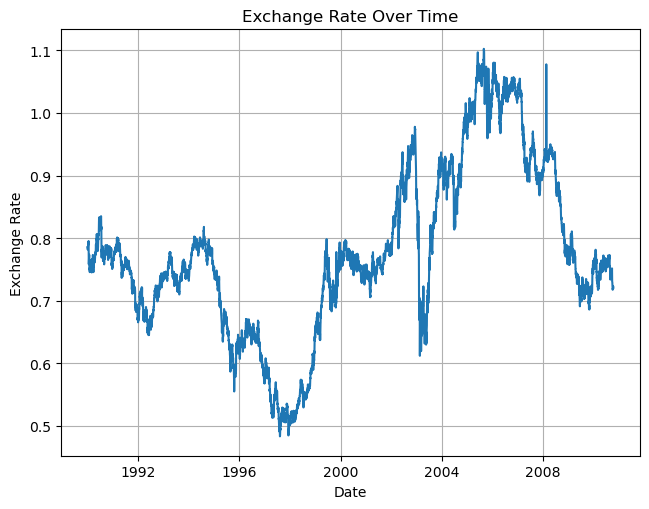

In [13]:
# Step 3: Plot Time Series
# Plot the time series
plt.plot(df['date'], df['Ex_rate'])
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.grid()

# Part 2: Model Building - ARIMA

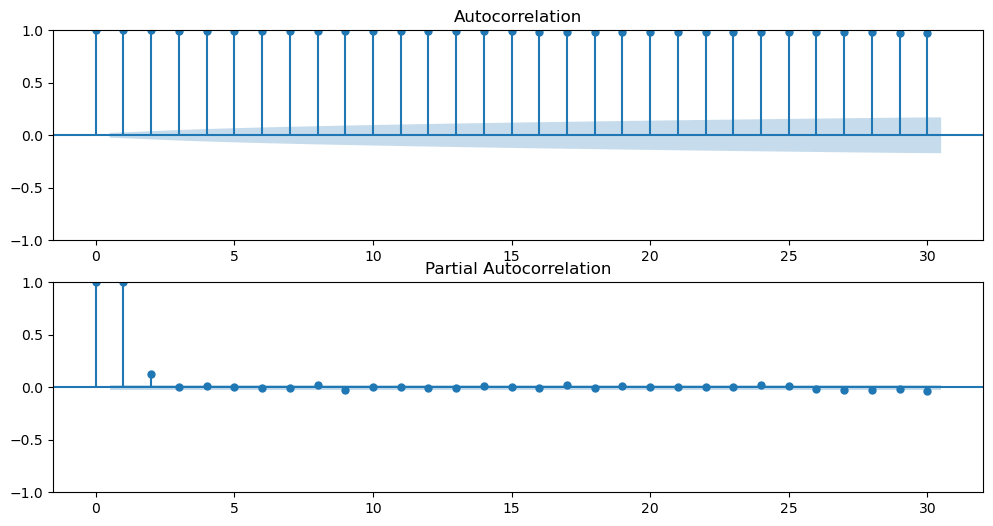

In [16]:
# 1. To estimate the initial parameters (p, d, q) for the ARIMA model, we will utilize ACF and PACF plots.
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(df['Ex_rate'], lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Ex_rate'], lags=30, ax=ax[1])
plt.show()

In [18]:
# 2. Model Fitting : Now that we have estimated the initial parameters (p, d, q)==(1,1,1) for the ARIMA model, we can fit the model to the preprocessed time series.
# Fit ARIMA model
model = sm.tsa.ARIMA(df['Ex_rate'], order=(1, 1, 1))
results = model.fit()

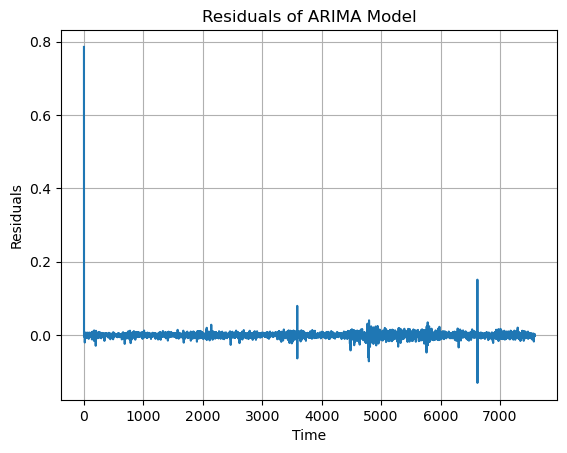

In [20]:
# 3. Diagnostics : To ensure that the ARIMA model is adequate, we need to analyze the residuals.
# Plot residuals
residuals = results.resid
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals of ARIMA Model')
plt.grid()

#If the residuals appear to be randomly scattered around zero, then the ARIMA model is likely adequate.

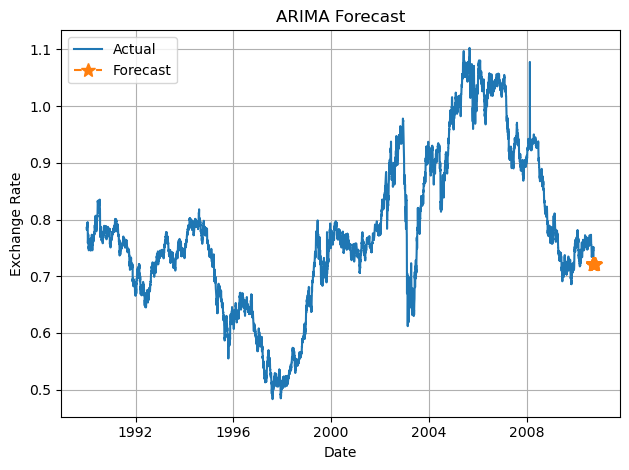

In [22]:
# 4. Forecasting: Finally, we can use the ARIMA model to perform out-of-sample forecasting
# Forecast future values
forecast = results.forecast(steps=30)

# Plot forecasted values
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(df['date'][-30:], forecast, label='Forecast',linestyle='--',marker='*',markersize=10)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('ARIMA Forecast')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Part 3: Model Building - Exponential Smoothing

In [25]:
# we will choose Holt's Linear Trend model.
# Parameter Optimization: To find the optimal parameters for the smoothing levels and components, we can use techniques such as grid search or AIC.
from statsmodels.tsa.holtwinters import Holt

# Define the parameter grid
param_grid = {'smoothing_level': [0.1, 0.3, 0.5], 'smoothing_trend': [0.1, 0.3, 0.5]}

# Perform grid search
best_params = None
best_score = float('inf')
for smoothing_level in param_grid['smoothing_level']:
    for smoothing_trend in param_grid['smoothing_trend']:
        model = Holt(df['Ex_rate'], exponential=True)
        # Used smoothing_level and smoothing_trend instead of alpha and beta
        model_fit = model.fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend)
        score = model_fit.aic
        if score < best_score:
            best_score = score
            best_params = (smoothing_level, smoothing_trend)

print('Optimal parameters:', best_params)

Optimal parameters: (0.5, 0.1)


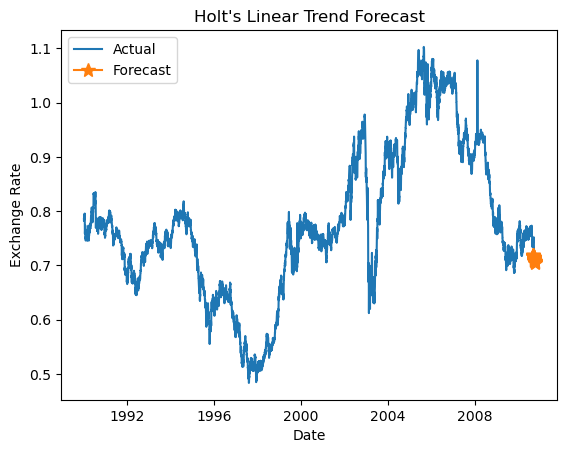

In [27]:
# Model Fitting and Forecasting:Now that we have found the optimal parameters, we can fit the Holt's Linear Trend model and forecast future values.

# Fit the model
model = Holt(df['Ex_rate'], exponential=True)
# Used smoothing_level and smoothing_trend instead of alpha and beta
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[1])
# Forecast future values
forecast = model_fit.forecast(steps=30)

# Plot forecasted values
plt.plot(df['date'], df['Ex_rate'], label='Actual')
plt.plot(df['date'][-30:], forecast, label='Forecast',markersize=10,marker='*',linestyle='solid')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Holt\'s Linear Trend Forecast')
plt.legend()
plt.show()

# Part 4: Evaluation and Comparison

In [30]:
# Compute Error Metrics: To evaluate the forecasts from both models, we can use metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Compute error metrics for ARIMA model
arima_forecast = results.forecast(steps=30)
arima_mae = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], arima_forecast))
arima_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], arima_forecast)

# Compute error metrics for Holt's Linear Trend model
holt_forecast = model_fit.forecast(steps=30)
holt_mae = mean_absolute_error(df['Ex_rate'][-30:], holt_forecast)
holt_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], holt_forecast))
holt_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], holt_forecast)

print('ARIMA Model Error Metrics:')
print('MAE:', arima_mae)
print('RMSE:', arima_rmse)
print('MAPE:', arima_mape)

print('\nHolt\'s Linear Trend Model Error Metrics:')
print('MAE:', holt_mae)
print('RMSE:', holt_rmse)
print('MAPE:', holt_mape)

ARIMA Model Error Metrics:
MAE: 0.012724006489318252
RMSE: 0.016982710912774826
MAPE: 1.7119209757097404

Holt's Linear Trend Model Error Metrics:
MAE: 0.02033885085956986
RMSE: 0.021993147748210314
MAPE: 2.7582255339119266


In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for ARIMA model
arima_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], arima_forecast)
print('ARIMA Model MAPE:', arima_mape)

# Calculate MAPE for Holt's Linear Trend model
holt_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], holt_forecast)
print('Holt\'s Linear Trend Model MAPE:', holt_mape)

ARIMA Model MAPE: 1.7119209757097404
Holt's Linear Trend Model MAPE: 2.7582255339119266


# **Model Comparison**

**ARIMA Model**

---
**Advantages:** Handles non-stationarity and seasonality

**Limitations:** Computationally expensive, requires careful parameter selection

**Performance:** MAE=0.01, RMSE=0.016, MAPE=1.71%

**Holt's Linear Trend Model**

---
**Advantages:** Simple, computationally efficient

**Limitations:** Assumes linear trend, no seasonality

**Performance:** MAE=0.020, RMSE=0.021, MAPE=2.75%

# **Conclusion**

The ARIMA model demonstrates lower values across all key error metrics (MAE, RMSE, and MAPE) compared to the Holt's Linear Trend model. This indicates that the ARIMA model provides more accurate and reliable forecasts for the exchange rates in your dataset.